In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import pickle

In [4]:
df=pd.read_csv("Credit Score Classification Dataset.csv")
df

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High
...,...,...,...,...,...,...,...,...
159,29,Female,27500,High School Diploma,Single,0,Rented,Low
160,34,Male,47500,Associate's Degree,Single,0,Rented,Average
161,39,Female,62500,Bachelor's Degree,Married,2,Owned,High
162,44,Male,87500,Master's Degree,Single,0,Owned,High


In [5]:
df.duplicated().value_counts()
df.isna().sum()

Age                   0
Gender                0
Income                0
Education             0
Marital Status        0
Number of Children    0
Home Ownership        0
Credit Score          0
dtype: int64

In [6]:
df['Education'].unique().tolist()

["Bachelor's Degree",
 "Master's Degree",
 'Doctorate',
 'High School Diploma',
 "Associate's Degree"]

In [7]:
df.dtypes

Age                    int64
Gender                object
Income                 int64
Education             object
Marital Status        object
Number of Children     int64
Home Ownership        object
Credit Score          object
dtype: object

In [8]:
df.describe()

,Age,Income,Number of Children
count,164.000000,164.000000,164.000000
mean,37.975610,83765.243902,0.652439
std,8.477289,32457.306728,0.883346
min,25.000000,25000.000000,0.000000
25%,30.750000,57500.000000,0.000000
50%,37.000000,83750.000000,0.000000
75%,45.000000,105000.000000,1.000000
max,53.000000,162500.000000,3.000000


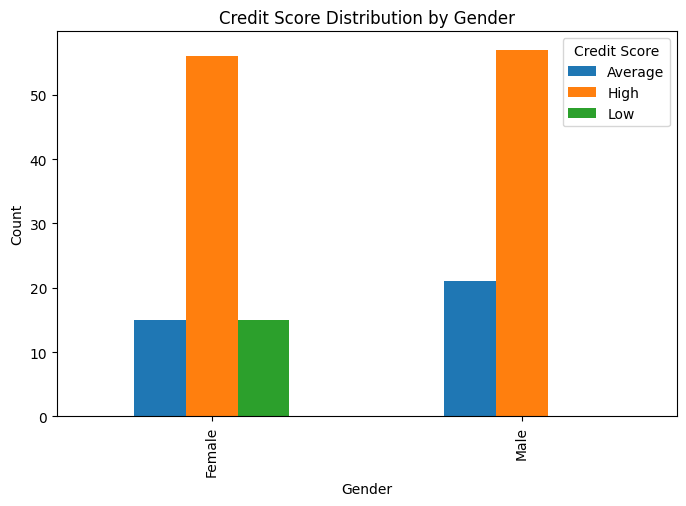

In [9]:
count_data=df.groupby(["Gender","Credit Score"]).size().unstack(fill_value=0)
count_data.plot(kind="bar", figsize=(8,5))
plt.title("Credit Score Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Credit Score")
plt.show()

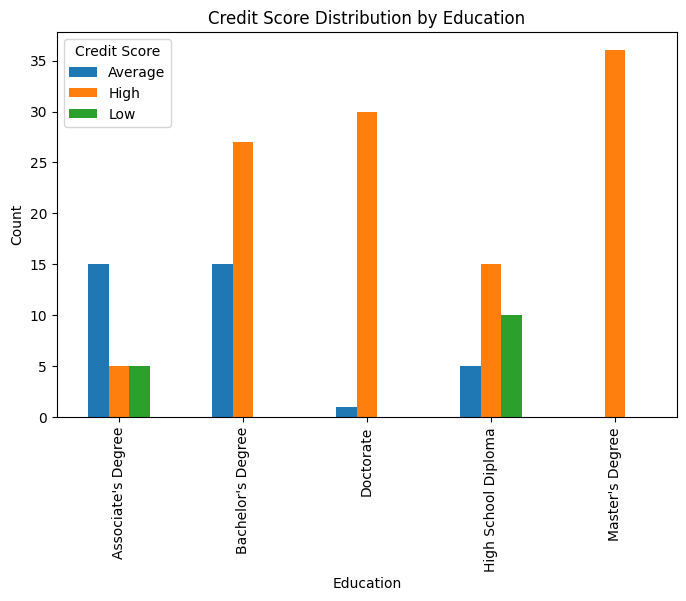

In [10]:
count_data=df.groupby(["Education","Credit Score"]).size().unstack(fill_value=0)
count_data.plot(kind="bar", figsize=(8,5))
plt.title("Credit Score Distribution by Education")
plt.xlabel("Education")
plt.ylabel("Count")
plt.legend(title="Credit Score")
plt.show()

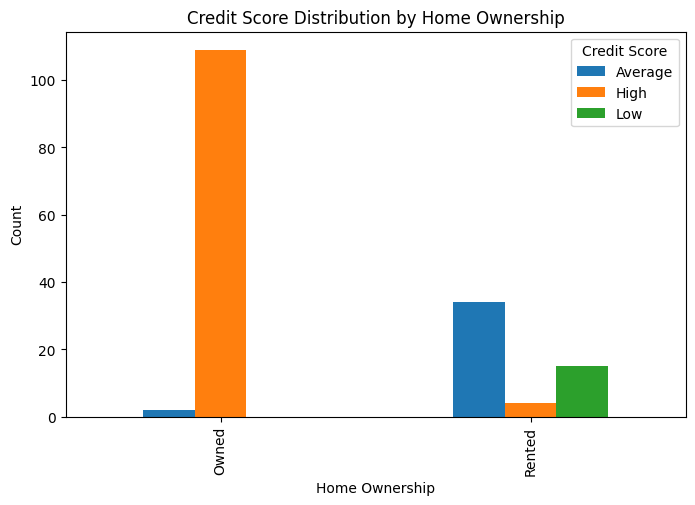

In [11]:
count_data=df.groupby(["Home Ownership","Credit Score"]).size().unstack(fill_value=0)
count_data.plot(kind="bar", figsize=(8,5))
plt.title("Credit Score Distribution by Home Ownership")
plt.xlabel("Home Ownership")
plt.ylabel("Count")
plt.legend(title="Credit Score")
plt.show()

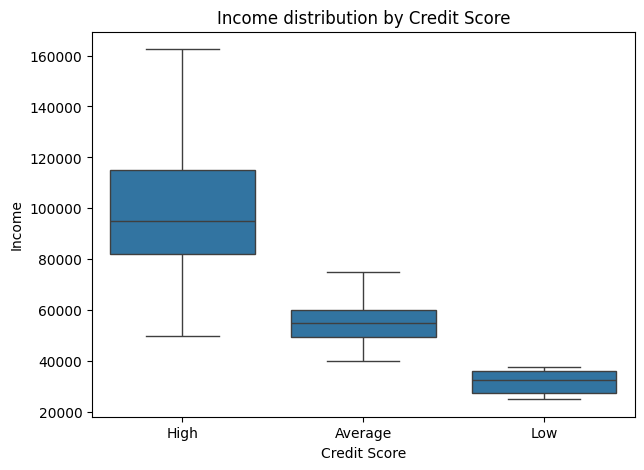

In [12]:
plt.figure(figsize=(7,5))
sns.boxplot(x="Credit Score",y="Income",data=df)
plt.title("Income distribution by Credit Score")
plt.show()

In [13]:
def detect_outliers_iqr(data,column):
    q1=data[column].quantile(0.25)
    q3=data[column].quantile(0.75)
    iqr=q3-q1
    lower_bound=q1-1.5*iqr
    upper_bound=q3+1.5*iqr
    outliers=data[(data[column]<lower_bound)|(data[column]>upper_bound)]
    return outliers

In [14]:
for i in df:
    if df[i].dtype in [int,float]:
        outliers=detect_outliers_iqr(df,i)
        print(f"Feature {i} -> Outliers detected={len(outliers)}")

Feature Age -> Outliers detected=0
Feature Income -> Outliers detected=0
Feature Number of Children -> Outliers detected=5


In [15]:
X=df.drop('Credit Score',axis=1)
y=df['Credit Score']

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
X_train.shape,y_train.shape

((131, 7), (131,))

In [18]:
#Encoding
encoders={}
for i in df:
    if df[i].nunique()==2:
        le=LabelEncoder()
        le.fit(df[i])
        X_train[i]=le.transform(X_train[i])
        X_test[i]=le.transform(X_test[i])
        encoders[i]=le
onehot=OneHotEncoder(drop='first',sparse_output=False)
train_encoded=onehot.fit_transform(X_train[['Education']])
test_encoded=onehot.transform(X_test[['Education']])
encoded_cols=onehot.get_feature_names_out(['Education'])
train_encoded_df=pd.DataFrame(train_encoded,columns=encoded_cols,index=X_train.index)
test_encoded_df=pd.DataFrame(test_encoded,columns=encoded_cols,index=X_test.index)
X_train=X_train.drop('Education',axis=1).join(train_encoded_df)
X_test=X_test.drop('Education',axis=1).join(test_encoded_df)
mapping={"Low":0,"Average":1,"High":2}
y_train=y_train.map(mapping)
y_test=y_test.map(mapping)

In [19]:
for i in df:
    if df[i].nunique()==2:
        print(encoders[i].classes_)


['Female' 'Male']
['Married' 'Single']
['Owned' 'Rented']


In [20]:
encoders

{'Gender': LabelEncoder(),
 'Marital Status': LabelEncoder(),
 'Home Ownership': LabelEncoder()}

In [21]:
#Model Training
model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("Accuracy score=",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy score= 0.9393939393939394
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.96      0.96      0.96        23

    accuracy                           0.94        33
   macro avg       0.92      0.92      0.92        33
weighted avg       0.94      0.94      0.94        33

[[ 5  0  0]
 [ 0  4  1]
 [ 0  1 22]]


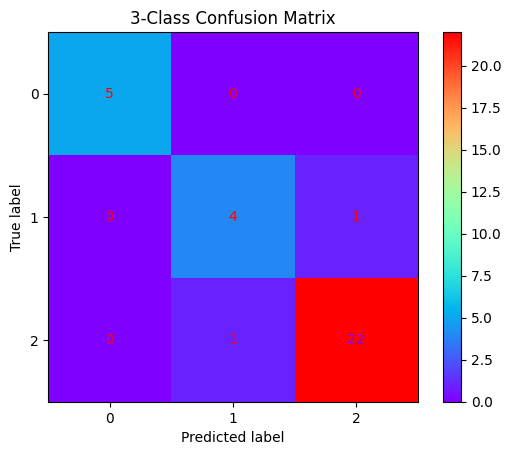

In [22]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap=plt.cm.rainbow)
plt.title("3-Class Confusion Matrix")
plt.show()

In [23]:
#Hyperparameter Tuning
param_grid={"n_estimators":[50,100,200],"max_depth":[None,5,10],"min_samples_split":[2,5,10]}
rf=RandomForestClassifier(random_state=42)
grid_search=GridSearchCV(rf,param_grid=param_grid,cv=5,scoring="accuracy")
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [24]:
grid_search.best_params_
best_model=grid_search.best_estimator_

In [25]:
#Model Evaluation
y_pred=best_model.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9393939393939394
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.96      0.96      0.96        23

    accuracy                           0.94        33
   macro avg       0.92      0.92      0.92        33
weighted avg       0.94      0.94      0.94        33

[[ 5  0  0]
 [ 0  4  1]
 [ 0  1 22]]


In [26]:
#Saving label encoder
with open("le_encoder.pkl","wb") as f:
    pickle.dump(encoders,f)
#Saving onehot encoder
with open("oh_encoder.pkl","wb") as f:
    pickle.dump(onehot,f)
#Saving model 
with open("model.pkl","wb") as f:
    pickle.dump(best_model,f)
#Saving feature names
feature_names=X_train.columns.tolist()
with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names,f)